<a href="https://colab.research.google.com/github/NachuanLi/demo/blob/master/high_way_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [36]:
vic={"av":1, "pos":[0,3], "speed":130, "acceleration":0, "lane_change":-1, "aggressive":False, "route":1}
def initialization(av=1,ini_pos=[0,3],aggressive=False, route=1, lane_change=-1,lane_speed={1:100,2:120,3:130},plt_lane=[3], flow_rate=3000,av_rate=0.4, av_time_rate=0.9, max_plt_size=7, min_headway=1, plt_catchup_distance=100, forward=4, backward=2, min_inter_gap=5 ):
  #self
  self_lane=ini_pos[1]
  if self_lane in plt_lane:
    speed=lane_speed[self_lane]
  else:
    speed=np.random.normal(lane_speed[self_lane],5)
  self={"av":av, "pos":ini_pos, "speed":speed, "acceleration":0, "lane_change":lane_change, "aggressive":aggressive, "route":route}
  #{"av":1, "pos":[0,3], "speed":130, "acceleration":0, "lane_change":-1, "aggressive":False, "route":1}
  #flowrate perlane
  manual_flow=flow_rate*(1-av_rate)+flow_rate*av_rate*(1-av_time_rate)
  av_flow=flow_rate*av_rate*av_time_rate
  sum_manual_speed=0
  sum_plt_speed=0
  for lane in lane_speed:
    if not lane in plt_lane:
      sum_manual_speed+=lane_speed[lane]
    else:
      sum_plt_speed+=lane_speed[lane]
  
  
  lane_flow={}
  #plt_flow_rate={}
  for lane in lane_speed:
    if lane in plt_lane:
      lane_flow[lane]=av_flow*lane_speed[lane]/sum_plt_speed
    elif not lane in plt_lane:
      lane_flow[lane]=manual_flow*lane_speed[lane]/sum_manual_speed
  #random pltsize
  plt_size_list=[x for x in range(1, max_plt_size+1)]
  plt_prob={}
  cud=plt_catchup_distance/1000 #convert to km
  for lane in plt_lane:
    plt_prob_list=[]
    fr=lane_flow[lane]
    sp=lane_speed[lane]
    for s in plt_size_list:
      if s!=max_plt_size:
        plt_prob_list.append(((1-math.exp(-fr*cud/sp))**(s-1))*math.exp(-fr*cud/sp))
      elif s==max_plt_size:
        plt_prob_list.append(1-sum(plt_prob_list))
    plt_prob[lane]=plt_prob_list
  print(plt_prob)
  print(lane_flow)

  #start vehicle generation: forward and backward, on each lane
  veh_list={}
  x=ini_pos[0]
  y=ini_pos[1]
  for lane in lane_speed:
    fr=lane_flow[lane]
    veh_list[lane]=[]
    #print(fr)
    if not (lane in plt_lane):
      gap_f=0
      for i in range(forward):
        #if i=0 and lane!=x:

        spacing=max(np.random.exponential(1/fr)*(lane_speed[lane])*1000,5)
        gap_f+=spacing#need change##################################################
        #print("gapf"+str(spacing))
        veh_list[lane].append({"av":random.choices([0,1],[1-av_rate,av_rate*(1-av_time_rate)])[0], "pos":[x+gap_f,lane], "speed":np.random.normal(lane_speed[self_lane],5), "acceleration":0, "lane_change":0, "agressive":aggressive, "route":route})
      gap_b=0
      for i in range(backward):
        spacing=max(np.random.exponential(1/fr)*(lane_speed[lane])*1000,5)
        gap_b+=spacing
        veh_list[lane].append({"av":random.choices([0,1],[1-av_rate,av_rate*(1-av_time_rate)])[0], "pos":[x-gap_b,lane], "speed":np.random.normal(lane_speed[self_lane],5), "acceleration":0, "lane_change":0, "agressive":aggressive, "route":route})
    elif lane in plt_lane:
      ft=ini_pos[0]
      bk=ini_pos[0]
      veh_list[lane]=[]
    
      if y==lane:
        self_plt=[]
        self_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        self_position=random.choices([k for k in range(1, self_plt_size+1)])[0]
        ft=x+(self_position-1)*min_headway/3600*lane_speed[lane]*1000
        bk=x+(self_position-self_plt_size)*min_headway/3600*lane_speed[lane]*1000
        for i in range(1, self_plt_size+1):
          posx=x+(self_position-i)*min_headway/3600*lane_speed[lane]*1000
          self_plt.append({"av":1, "pos":[posx,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
      #fg=0
        veh_list[lane].append(self_plt)
      else:
        reference_plt=[]
        reference_plt_size=random.choices(plt_size_list,plt_prob[lane])[0]
        reference_pos=x+np.random.exponential(1/(fr/reference_plt_size))*lane_speed[lane]*1000   ##################################

        ft=reference_pos
        bk=reference_pos-(reference_plt_size)*min_headway*lane_speed[lane]/3.6
        for i in range(1,reference_plt_size+1):
          posx=reference_pos-(i-1)*min_headway*lane_speed[lane]/3.6
          reference_plt.append({"av":1, "pos":[posx,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
        veh_list[lane].append(reference_plt)

      for i in range(forward//4):
        front_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        platoon=[]
        ###########
        print("frontpltsize:"+str(front_plt_size))
        ft+=max(np.random.exponential(1/(fr/front_plt_size))*lane_speed[lane]*1000,(front_plt_size+min_inter_gap)*min_headway*lane_speed[lane]/3.6)################################################
        print("ft:"+str(ft))
        for num in range(front_plt_size):
          intra=num*min_headway*lane_speed[lane]/3.6
          

          platoon.append({"av":1, "pos":[ft-intra,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
          

        
        veh_list[lane].append(platoon)
        
        back_plt_size=0
      for i in range(backward//4):
        threshold=back_plt_size+min_inter_gap
        back_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        bk-=max(np.random.exponential(1/(fr/back_plt_size))*lane_speed[lane]*1000,threshold*min_headway*lane_speed[lane]/3.6)###########
        #back_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        platoon=[]

        ################################################

        for num in range(back_plt_size):
          intra=num*min_headway/3600*lane_speed[lane]*1000
          platoon.append({"av":1, "pos":[bk-intra,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
        
        veh_list[lane].append(platoon)
      
      xlst=[]
      ylst=[]
      n=[]
      m=[]
      for lane in veh_list:
        if type(veh_list[lane][0])==list:
          for platoon in veh_list[lane]:
            for veh in platoon:
              xlst.append(veh["pos"][0])
              ylst.append(veh["pos"][1])
              pass
        else:
          for veh in veh_list[lane]:
            #print(veh)
            xlst.append(veh["pos"][0])
            ylst.append(veh["pos"][1])

        plt.scatter(xlst,ylst)
        #plt.scatter([x],[y])

      return veh_list
      #print(veh_list[3])
      #for l in veh_list[2]:
        #print(len(l))
      
       


#initialization()

      
            

            


      












{3: [0.43571399276918776, 0.24586730927431996, 0.13873948225898927, 0.07828874848919516, 0.04417724529606522, 0.024928601358572822, 0.03228462055366976]}
{1: 872.7272727272727, 2: 1047.2727272727273, 3: 1080.0}
frontpltsize:4
ft:466.9814821521653


{1: [{'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [68.61857209883641, 1],
   'route': 1,
   'speed': 136.19574734917018},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [108.8941773409353, 1],
   'route': 1,
   'speed': 136.77794915832277},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [130.77059279618484, 1],
   'route': 1,
   'speed': 137.51298017663757},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [135.77059279618484, 1],
   'route': 1,
   'speed': 123.00222362880466},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-102.82563841909848, 1],
   'route': 1,
   'speed': 131.80472187257942},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-245.84303674765744, 1],
   'route': 1,
   'speed': 140.01792793154866}],
 2: [{'acceleration': 0,
   'a

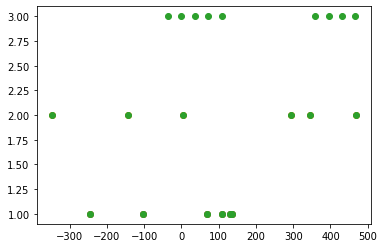

In [37]:
vl=initialization()
vl

{1: {}, 0: {'front': [[{'av': 1, 'pos': [1853.2989058361604, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1817.1877947250493, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1781.0766836139383, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1744.9655725028272, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1708.854461391716, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 1853.2989058361604, 1708.854461391716], 'close': [[[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [-36.11111111111111, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 0.0, -36.11111111111111]]}, -1: {'back': [{'av': 0

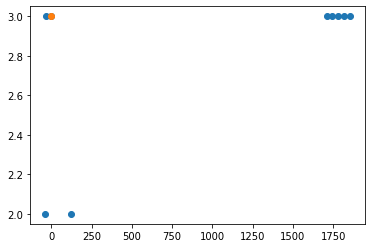

In [5]:
def get_nei(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130}):
  x=veh["pos"][0]
  y=veh["pos"][1]
  nei_dic={1:{}, 0:{}, -1:{}}
  for i in [-1,0,1]:
    if y+i in lane_speed:
      if not (y+i in plt_lane):
        fv=None
        fp=1000000
        bv=None
        bp=-1000000
        soclose=[]
        for veh in veh_list[y+i]:
          xpos=veh["pos"][0]
          if xpos<fp and xpos>x+min_headway*lane_speed[y+i]/3.6:
            fp=xpos
            fv=veh
          if xpos>bp and xpos<x-min_headway*lane_speed[y+i]/3.6:
            bp=xpos
            bv=veh
          if xpos>x-min_headway*lane_speed[y+i]/3.6 and xpos<x+min_headway*lane_speed[y+i]/3.6 and xpos!=x :
            soclose.append([veh,xpos-x])
        if bp!=-1000000: 
          nei_dic[i]["back"]=[bv,bp-x]
        if fp!=1000000:
          nei_dic[i]["front"]=[fv,fp-x]
        if soclose!=[]:
          nei_dic[i]["close"]=soclose

      elif y+i in plt_lane:
        fpos=100000
        fpos2=None
        bpos=-1000000
        bpos2=None
        fp=None
        bp=None
        soclose=[]
        for platoon in veh_list[y+i]:
          if type(platoon)==list:
            v_pos=[v["pos"][0] for v in platoon]
            plt_f=max(v_pos)
            plt_b=min(v_pos)
            if plt_b>x+min_headway*lane_speed[y+i]/3.6 and plt_f<fpos:
              fpos=plt_f
              fpos2=plt_b
              fp=platoon
            if plt_f<x-min_headway*lane_speed[y+i]/3.6 and plt_b>bpos:
              bpos=plt_f
              bpos2=plt_b
              bp=platoon
            if (plt_f>x and plt_b<x) or (plt_f<x+min_headway*lane_speed[y+i]/3.6 and plt_f>x-min_headway*lane_speed[y+i]/3.6) or (plt_b<x+min_headway*lane_speed[y+i]/3.6 and plt_b>x-min_headway*lane_speed[y+i]/3.6):
              soclose.append([platoon, plt_f-x, plt_b-x])
        if bpos2!=None:
          nei_dic[i]["back"]=[bp, bpos-x, bpos2-x]
        if fpos2!=None:
          nei_dic[i]["front"]=[fp, fpos-x, fpos2-x]
        if soclose!=[]:
          nei_dic[i]["close"]=soclose
  print(nei_dic)
  x_list=[]
  y_list=[]
  for key in nei_dic:
    if nei_dic[key]!={}:
      for a in nei_dic[key]:#a is back, front or close
        print(nei_dic[key][a]) 
        
        if type(nei_dic[key][a][0])==dict:
          x_list.append(nei_dic[key][a][0]["pos"][0])
          y_list.append(nei_dic[key][a][0]["pos"][1])
          #print(nei_dic[key][a])
        elif type(nei_dic[key][a][0])==list:
          if type(nei_dic[key][a][0][0])==dict:
            for v in nei_dic[key][a][0]:
              if type(v)==dict:
                x_list.append(v["pos"][0])
                y_list.append(v["pos"][1])
          elif type(nei_dic[key][a][0][0])==list:
            print(nei_dic[key][a][0])
            for k in nei_dic[key][a][0]:
              print("k")
              print(k)
              if type(k)==list:
                for v in k:
                  print("v")
                  print(v)
                  if type(v)==dict:
                    x_list.append(v["pos"][0])
                    y_list.append(v["pos"][1])
          
  plt.scatter(x_list,y_list)
  plt.scatter([x],[y])

  return nei_dic

nvl=get_nei()






{1: {'front': [[{'av': 1, 'pos': [1853.2989058361604, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1817.1877947250493, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1781.0766836139383, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1744.9655725028272, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1708.854461391716, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 1853.2989058361604, 1708.854461391716]}, 0: {'back': [{'av': 0, 'pos': [-36.798709127111145, 2], 'speed': 124.49696355027373, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, -36.798709127111145], 'front': [{'av': 0, 'pos': [119.2536402892229, 2], 'speed': 119.3747430706101, 'acceleration': 0, 'lane_change': 0, 'agressive': Fa

{-1: [True, 372.0139382753106, -39.770037364412076],
 0: [True, 119.2536402892229, -36.798709127111145],
 1: [True, 1708.854461391716, -10000]}

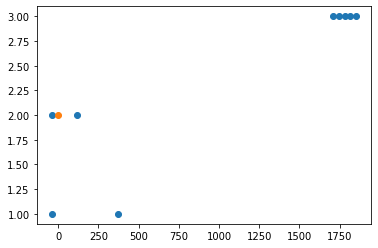

In [13]:
# no close vehicle 

vic={'av': 0, 'pos': [0, 2], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}
def gap_eval(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130}):
  nvl=get_nei(veh=veh,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  lane_change=veh["lane_change"]
  self_gap_safe=True
  left_change_possible=False
  right_change_possible=False
  frontgaps={-1:None,0:None,1:None}
  backgaps={-1:None,0:None,1:None}


  for key in nvl:
    
    if nvl[key]!={}:
      nei_pos=[] 
      if veh["pos"][1]+key in plt_lane:

        
        for k in nvl[key]:
          if k!="close":
            if nvl[key][k][2]>0 and nvl[key][k][1]>0:
              nei_pos.append(min(nvl[key][k][2],nvl[key][k][1]))
            elif nvl[key][k][2]<0 and nvl[key][k][1]<0:
              nei_pos.append(max(nvl[key][k][2],nvl[key][k][1]))
            else:
              nei_pos.append(0)
          else:
            #print(nvl)
            for p in nvl[key]["close"]:
              if p[1]>0 and p[2]>0:
                nei_pos.append(min(p[1],p[2]))
              elif p[1]<0 and p[2]<0:
                nei_pos.append(max(p[1],p[2]))
              else:
                nei_pos.append(0)

      elif not veh["pos"][1]+key in plt_lane:
        for k in nvl[key]:
          if k!="close":
            nei_pos.append(nvl[key][k][1])
          else:
            for p in nvl[key]["close"]:
              nei_pos.append(p[1])

      fgl=[g for g in nei_pos if g>=0]
      bgl=[g for g in nei_pos if g<0]
      try:
        frontgaps[key]=min(fgl)
      except:
        frontgaps[key]=10000
      try:
        backgaps[key]=max(bgl)
      except:
        backgaps[key]=-10000
      if key!=0:
        if not ("close" in nvl[key]):
          if key==-1 and lane_change!=1:
            right_change_possible=True
            
          if key==1 and lane_change!=-1:
            left_change_possible=True
            if veh["av"]==0 and veh["pos"][1]+lane_change in plt_lane:
              left_change_possible=False
      elif key==0:
        if frontgaps[key]<=lane_speed[veh["pos"][1]]/3.6*min_headway:
          self_gap_safe=False




  return {1:[left_change_possible,frontgaps[1],backgaps[1]],-1:[right_change_possible,frontgaps[-1],backgaps[-1]],0:[self_gap_safe, frontgaps[0],backgaps[0]]}

gap_eval()









In [ ]:

def manual_speed_reduction(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130}):
  x=veh["pos"][0]
  y=veh["pos"][1]
  print(veh_list)
  vidx=veh_list[y].index(veh)#what if not in 
  nv_list=get_nei(veh=veh,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  same_lane_list=nv_list[0]
  veh["speed"]=np.random.normal(lane_speed[y],5)
  if not y in plt_lane:
    if ("close" in nv_list[0]):
      gp=gap_eval(veh=vic,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
      
      if gp[0][0]==False:#cls_lst[1]>x and cls[0]["speed"]<=veh["speed"]-5:
        print("speed reduction")
        veh["speed"]-=3
        veh_list[y][vidx]=veh
  return veh,veh_list
manual_speed_reduction()



In [ ]:
def lane_change(veh=vic, veh_list=vl, plt_lane=[3],lane_speed={1:120,2:120,3:130}):
  vidx=veh_list[veh["pos"][1]].index(veh)
  if not veh["pos"][1]
  veh["pos"][1]+=veh["lane_change"]
  #veh["pos"][0]+=veh["speed"]/3.6
  if veh["pos"][1] in plt_lane:
    veh["speed"]=lane_speed[veh["pos"][1]]
  else:
    if veh["lane_change"]!=0:
      veh["speed"]=np.random.normal(lane_speed[veh["pos"][1]],5)
  veh["lane_change"]=0
  veh_list[veh["pos"][1]][vidx]=veh
  
  return veh,veh_list
  
    

lane_change()


In [8]:
def platoon_full(plt_lane=[3],veh_list=vl, lane_speed={1:120,2:120,3:130}, min_intra_space=5, min_headway=1):
  platoon_full={}
  for lane in plt_lane:
    veh_count=0
    plt_count=0
    min_pos=0
    max_pos=0
    for platoon in veh_list[lane]:
      plt_count+=1
      for veh in platoon:
        veh_count+=1
        if veh["pos"][0]>max_pos:
          max_pos=veh["pos"][0]
        if veh["pos"][0]<min_pos:
          min_pos=veh["pos"][0]
    distance=max_pos-min_pos
    print(max_pos)
    print(min_pos)
    print(veh_count)
    print(plt_count)
    average_spacing=distance/(veh_count+plt_count*min_intra_space+1)
    if average_spacing <min_headway*lane_speed[lane]/3.6:
      platoon_full[lane]=True
    else:
      platoon_full[lane]=False

  return platoon_full

platoon_full()



  

1853.2989058361604
-36.11111111111111
7
2


{3: False}

In [9]:
def pop_from_platoon(veh_list=vl, veh=vic, plt_lane=[3]):
  lc=veh["lane_change"]
  #print(veh["pos"])
  for lane in veh_list:
    if lane in plt_lane:
      for platoon in veh_list[lane]:
        thresh_p=-1000000
        for ve in platoon:
          #print(platoon)
          
          if veh["pos"]==ve["pos"]:         
            thresh_p=veh["pos"][0]
            platoon.pop(platoon.index(veh))
            if not lane+lc in plt_lane:
              veh=lane_change(veh)
              print(lane+lc)
              veh_list[lane+lc].append(veh)
            elif (lane+lc) in plt_lane:
                #join_plt(veh_list, veh)
              pass
            
        for v in platoon:
          if v["pos"][0]<thresh_p:
            v["acceleration"]=5
    return veh,veh_list


           
          





In [10]:

pp=pop_from_platoon()
vlst=pp[0]
vc=pp[1]
get_nei(veh=vc, veh_list=vlst)

KeyError: ignored

In [ ]:
 q={'av': 1, 'pos': [0, 3], 'speed': 5, 'acceleration': 0, 'lane_change': 1, 'aggressive': False, 'route': 1}
 get_nei(veh=q,veh_list=vl)

In [41]:
vl={1: [{'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [150.67021778039265, 1],
   'route': 1,
   'speed': 121.80576770793196},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [201.78205240706563, 1],
   'route': 1,
   'speed': 122.81967747085633},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [216.07203873842255, 1],
   'route': 1,
   'speed': 132.58079721915516},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [274.0285807080048, 1],
   'route': 1,
   'speed': 127.61216287485085},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-53.129777419380716, 1],
   'route': 1,
   'speed': 128.58804669703426},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-120.67592432557088, 1],
   'route': 1,
   'speed': 120.38652462471842}],
 2: [{'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [65.23008154824869, 2],
   'route': 1,
   'speed': 128.23877630242754},
  {'acceleration': 0,
   'agressive': False,
   'av': 1,
   'lane_change': 0,
   'pos': [159.96070077622073, 2],
   'route': 1,
   'speed': 136.0914105891159},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [721.2928772928327, 2],
   'route': 1,
   'speed': 130.58027805220138},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [836.5247249241977, 2],
   'route': 1,
   'speed': 129.61370563593786},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-225.2991766509059, 2],
   'route': 1,
   'speed': 121.57880754356563},
  {'acceleration': 0,
   'agressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-462.8063845773767, 2],
   'route': 1,
   'speed': 131.70153840344554}],
 3: [[{'acceleration': 0,
    'aggressive': False,
    'av': 1,
    'lane_change': 0,
    'pos': [0.0, 3],
    'route': 1,
    'speed': 130},
   {'acceleration': 0,
    'aggressive': False,
    'av': 1,
    'lane_change': 0,
    'pos': [-36.11111111111111, 3],
    'route': 1,
    'speed': 130}],
  [{'acceleration': 0,
    'aggressive': False,
    'av': 1,
    'lane_change': 0,
    'pos': [216.66666666666666, 3],
    'route': 1,
    'speed': 130}]]}

this is veh list
{1: [{'acceleration': 0, 'agressive': False, 'av': 0, 'lane_change': 0, 'pos': [150.67021778039265, 1], 'route': 1, 'speed': 121.80576770793196}, {'acceleration': 0, 'agressive': False, 'av': 0, 'lane_change': 0, 'pos': [201.78205240706563, 1], 'route': 1, 'speed': 122.81967747085633}, {'acceleration': 0, 'agressive': False, 'av': 0, 'lane_change': 0, 'pos': [216.07203873842255, 1], 'route': 1, 'speed': 132.58079721915516}, {'acceleration': 0, 'agressive': False, 'av': 0, 'lane_change': 0, 'pos': [274.0285807080048, 1], 'route': 1, 'speed': 127.61216287485085}, {'acceleration': 0, 'agressive': False, 'av': 0, 'lane_change': 0, 'pos': [-53.129777419380716, 1], 'route': 1, 'speed': 128.58804669703426}, {'acceleration': 0, 'agressive': False, 'av': 0, 'lane_change': 0, 'pos': [-120.67592432557088, 1], 'route': 1, 'speed': 120.38652462471842}], 2: [{'acceleration': 0, 'agressive': False, 'av': 0, 'lane_change': 0, 'pos': [65.23008154824869, 2], 'route': 1, 'speed': 128.238

({'acceleration': 0,
  'aggressive': False,
  'av': 1,
  'lane_change': 1,
  'pos': [174, 3],
  'route': 1,
  'speed': 5},
 {1: [{'acceleration': 0,
    'agressive': False,
    'av': 0,
    'lane_change': 0,
    'pos': [150.67021778039265, 1],
    'route': 1,
    'speed': 121.80576770793196},
   {'acceleration': 0,
    'agressive': False,
    'av': 0,
    'lane_change': 0,
    'pos': [201.78205240706563, 1],
    'route': 1,
    'speed': 122.81967747085633},
   {'acceleration': 0,
    'agressive': False,
    'av': 0,
    'lane_change': 0,
    'pos': [216.07203873842255, 1],
    'route': 1,
    'speed': 132.58079721915516},
   {'acceleration': 0,
    'agressive': False,
    'av': 0,
    'lane_change': 0,
    'pos': [274.0285807080048, 1],
    'route': 1,
    'speed': 127.61216287485085},
   {'acceleration': 0,
    'agressive': False,
    'av': 0,
    'lane_change': 0,
    'pos': [-53.129777419380716, 1],
    'route': 1,
    'speed': 128.58804669703426},
   {'acceleration': 0,
    'agress

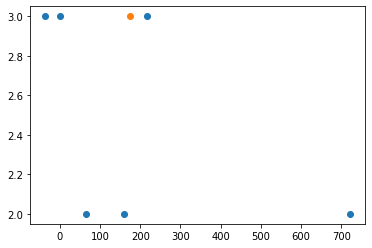

In [42]:
q={'av': 1, 'pos': [174, 3], 'speed': 5, 'acceleration': 0, 'lane_change': 1, 'aggressive': False, 'route': 1}
u={'av': 1, 'pos': [280, 3], 'speed': 5, 'acceleration': 0, 'lane_change': 1, 'aggressive': False, 'route': 1}
#will only assign individual vehicles in plt_lane with lane_change as 0
vl[3].append(q)
vl[3].append(u)
def join_platoon(veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5):
    raw_list=veh_list
    for l in plt_lane:
      for c in veh_list[l]:
        if type(c)==dict:
          print("this is veh list")
          print(veh_list)
          veh_list[l].pop(veh_list[l].index(c))
          cnei=get_nei(veh=c,veh_list=raw_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
          t_plt=None
          dist=1000
          for ps in cnei[0]:
            if ps!="close":
              if min(abs(cnei[0][ps][1]),abs(cnei[0][ps][2]))<dist:
                dist=min(cnei[0][ps][1],cnei[0][ps][2])
                t_plt=cnei[0][ps][0]
          #print("#########################tplt")
          print(t_plt)
          if t_plt!=None:
            idx=veh_list[l].index(t_plt)
            veh_list[l][idx].append(c)
          elif t_plt==None:
            veh_list[l].append([c])
    return c, veh_list 


join_platoon()
#fertig

In [ ]:
q={'av': 1, 'pos': [220, 2], 'speed': 5, 'acceleration': 0, 'lane_change': 1, 'aggressive': False, 'route': 1}
def join_platoon_old(veh=q, veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5):
  ne=get_nei(veh=veh,veh_list=veh_list)
  lc=veh["lane_change"]
  f_pos=max(ne[lc]["front"][1],ne[lc]["front"][2])
  b_pos=min(ne[lc]["back"][1],ne[lc]["back"][2])
  #nei=get_nei(veh,veh_list)
  o_lane=veh["pos"][1]
  new_lane=o_lane+lc
  if o_lane in plt_lane:
    ##some errors here to be fixed
    new_v=pop_from_platoon(veh_list=vl, veh=q, plt_lane=[3])[1]
    veh_list=pop_from_platoon(veh_list=vl, veh=q, plt_lane=[3])[0]

  elif not (o_lane in plt_lane):
    try:
      veh_list[o_lane].pop(veh_list[o_lane].index(veh))
    except:
      print("no such veh")
      pass
    q=lane_change(veh=veh, plt_lane=[3],lane_speed={1:120,2:120,3:130})
  
  
    veh_list[new_lane].append([q])
  
  if q["pos"][0]-f_pos>inter_gap*min_headway*lane_speed[new_lane]/3.6 and b_pos-q["pos"][0]>inter_gap*min_headway*lane_speed[new_lane]/3.6:
    veh_list[new_lane].append([q])
  else: 
    if q["pos"][0]-f_pos<b_pos-q["pos"][0]:
      q["acceleration"]=5
      #join front
      for platoon in veh_list[new_lane]:
        print(platoon)
        print(ne[lc]["front"][0])
        if platoon==ne[lc]["front"][0]:
          print("raw_back")
          print(platoon)
          veh_list[new_lane][veh_list[new_lane].index(platoon)]=platoon.append(q)
          print(platoon)
    elif q["pos"][0]-f_pos>b_pos-q["pos"][0]:
      #join back
      for platoon in veh_list[new_lane]:
        if platoon==ne[lc]["back"][0]:
          print("raw_front")
          print(platoon)
          veh_list[new_lane][veh_list[new_lane].index(platoon)]=platoon.append(q)
          print(platoon)


  return veh_list


join_platoon()

In [ ]:
p=[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [-5.11111111111111, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [-122.22222222222221, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [20, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}]
def update_plt(platoon=p, plt_lane=[3],min_headway=1,permutation=5, speed_increment=2):
  sorted_plt=sorted(platoon, key = lambda i: i['pos'][0], reverse=True)
  speed=sorted_plt[0]["speed"]
  acc_pos_list=[]
  dec_pos_list=[]
  dec_zone=False
  acc_zone=False
  for idx in range(1,len(sorted_plt)):
    if sorted_plt[idx]["pos"][0]<sorted_plt[idx-1]["pos"][0]-min_headway*speed/3.6-permutation: #and sorted_plt[idx]["speed"]<sorted_plt[idx-1]["speed"]+5:
      acc_zone=True
      dec_zone=False

    if sorted_plt[idx]["pos"][0]>sorted_plt[idx-1]["pos"][0]-min_headway*speed/3.6+permutation: #and sorted_plt[idx]["speed"]>sorted_plt[idx-1]["speed"]+5:
      acc_zone=False
      dec_zone=True
    if acc_zone==True and dec_zone==False:
      acc_pos_list.append(sorted_plt[idx]["pos"][0])
    if acc_zone==False and dec_zone==True:
      dec_pos_list.append(sorted_plt[idx]["pos"][0])
    print(sorted_plt[idx-1]["pos"][0]-sorted_plt[idx]["pos"][0])
  print(acc_pos_list)
  print("that was acc")
  print(dec_pos_list)
  print("that was dec")
  print(platoon)
  print("that was orig plt")
  for i in range(len(platoon)):
    platoon[i]["speed"]=sorted_plt[0]["speed"]
    if platoon[i]["pos"][0] in acc_pos_list: #and platoon[i-1]["speed"]>=platoon[i]["speed"]: # and platoon[i]["s"]<135:
      #platoon[i]["acceleration"]=5
      platoon[i]["speed"]+=speed_increment
    
    if platoon[i]["pos"][0] in dec_pos_list: #and platoon[i-1]["speed"]<=platoon[i]["speed"]: # and platoon[i]["speed"]>115:
      platoon[i]["speed"]-=speed_increment
  
  return platoon, 
    

m=sorted(update_plt(),key = lambda i: i["pos"][0])
m    
    
    
      
  


  

In [ ]:
def samelane_evolution(veh={'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 2, 'lane_change': 0, 'aggressive': False, 'route': 1}, t=1):
  new_posy=veh["pos"][1]
  new_posx=veh['pos'][0]+t*veh['speed']/3.6+(1/2)*veh["acceleration"]*t**2
  veh["pos"]=[new_posx,new_posy]
  veh["speed"]=veh["speed"]+veh["acceleration"]*t/3.6
  return veh
samelane_evolution()

In [ ]:
m=sorted(update_plt(),key = lambda i: i["pos"][0])
m
xl=[]
yl=[]
for i in m:
  xl.append(i["pos"][0])
  yl.append(i["pos"][1])
plt.scatter(xl,yl)

In [ ]:
#platoon continuous demo
import matplotlib.pyplot as plt
count=0
for i in range(0,200):
  count+=1
  m1=update_plt(platoon=m, plt_lane=[3],min_headway=1,permutation=3)
  newm=[]
  for vehi in m1:
    newm.append(samelane_evolution(veh=vehi,t=1))
    #print(newm)
  print(m1)
  x=[v["pos"][0] for v in m1]
  y=[v["pos"][1] for v in m1]
  s=m1[0]["speed"]
  b=True
  for v in m1:
    if v!=s:
      b=False
  if b:
    break
  print(count)

  


  m1=newm
plt.scatter(x,y)

In [ ]:
'''
# initialization, returns the vehicle network in terms of dic
initialization(av=1,ini_pos=[0,3],aggressive=False, route=1, lane_change=-1,lane_speed={1:100,2:120,3:130},plt_lane=[3], flow_rate=3000,av_rate=0.4, av_time_rate=0.9, max_plt_size=7, min_headway=1, plt_catchup_distance=100, forward=21, backward=14, min_inter_gap=5 ):
# returns the dic of neighboring vehicles (-1,1,0), for each there is front, back and so close
get_nei(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
# if efg. -1:[safe or unsafe, frontgap, backgap]
gap_eval(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
# reduce speed based on condition on the front vehicles, and changes deceleration, and speed (need to think more about this)
manual_speed_reduction(veh=vic,nv_list=nvl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
# returns a vehicle info after a lane change, including pos and speed
lane_change(veh=vic, plt_lane=[3],lane_speed={1:120,2:120,3:130})
# returns if a platoon is full in terms of a boolean value
platoon_full(plt_lane=[3],veh_list=vl, lane_speed={1:120,2:120,3:130}, min_intra_space=5, min_headway=1)
# returns veh_list, veh, which are the new vehile network dic and the new vehicle dic after exit
pop_from_platoon(veh_list=vl, veh=vic, plt_lane=[3])
# returns the new vehicle network after the platoon joning maneuver
join_platoon(veh=q, veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5)
# returns the new platoon after intra platoon maneuver after a certain period of time
update_plt(platoon=p, plt_lane=[3],min_headway=1,permutation=2)
# returns the evolution of a vehicle based on simple lane keeping
samelane_evolution(veh={'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 2, 'lane_change': 0, 'aggressive': False, 'route': 1}, t=1)
'''
#note: all functions that returns veh should also return the new veh_list

In [ ]:
def fastlane_rule(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
  av=veh["av"]
  rt=veh["route"]
  x=veh["pos"][0]
  y=veh["pos"][1]
  agg=veh["aggressive"]
  nei=get_nei(veh=veh,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  gaps=gap_eval(veh=veh, veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  for lc in gaps:
    if y+lc in plt_lane:
      gaps[lc][0]==False
  possible_lc={}
  for lc in gaps:
    if gaps[lc][0]==True or lc==0:
      possible_lc[lc]=gaps[lc][1]
  fastest_key=0
  max_g=0
  for key in possible_lc:
    if possible_lc[key]>max_g:
      max_g=possible_lc[key]
      fasted_key=key


  if agg==True:
    if not (gaps[-1][0]==False and gaps[0][0]==False and gaps[1][0]==False):
      veh["lane_change"]=fastest_key
      veh=lane_change(veh=veh, plt_lane=[3],lane_speed={1:120,2:120,3:130})
    #else:
      #manual_speed_reduction()
  elif agg==False:
    if gaps[0][0]==False:
      if len(possible_lc)>1:
        veh["lane_change"]=fastest_key
        veh=lane_change(veh=veh, plt_lane=[3],lane_speed={1:120,2:120,3:130})
  print("veh")
  print(fastest_key)
  print(veh)


fastlane_rule()
  


In [ ]:
def right_priority(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
   av=veh["av"]
   rt=veh["route"]
   x=veh["pos"][0]
   y=veh["pos"][1]
   #agg=veh["aggressive"]
   nei=get_nei(veh=veh,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
   gaps=gap_eval(veh=veh, veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
   if gaps[-1][0]==True:
     veh["lane_change"]=-1
     veh=lane_change(veh=veh, plt_lane=[3],lane_speed={1:120,2:120,3:130})

def left_priority(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
  av=veh["av"]
  rt=veh["route"]
  x=veh["pos"][0]
  y=veh["pos"][1]
  #agg=veh["aggressive"]
  nei=get_nei(veh=veh,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  gaps=gap_eval(veh=veh, veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  if gaps[1][0]==True:
    veh["lane_change"]=1
    veh=lane_change(veh=veh, plt_lane=[3],lane_speed={1:120,2:120,3:130})
  

def platoon_side_rule(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
   rp=min(plt_lane)
   lp=max(plt_lane)
   if y>max(plt_lane):
     right_priority(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000})
   elif y<min(plt_lane):
     left_priority(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000})
 



In [ ]:
def lane_change_eval(veh={'av': 1, 'pos': [0, 3], 'speed': 130.0, 'acceleration': 0, 'lane_change': -1, 'aggressive': False, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
   av=veh["av"]
   rt=veh["route"]
   x=veh["pos"][0]
   y=veh["pos"][1]
   exit_pos=exit_pos[rt]
   platoon_join_position_list=[[exit_pos[key]+interchange_len, exit_pos[key]+interchange_len+lane_change_pos] for key in exit_pos]
   platoon_join_position_list.append([0,0+lane_change_pos])
   if av==0:
     if rt=0 or x+lane_change_pos+np.random.normal(0,10)<exit_pos:
       fast_lane_rule()
     else:
       right_priority()
   elif av==1:
     in_join=False
     in_leave=False
     for r in platoon_join_pos_list:
       if x<r[1] and x>r[0]:
         in_join=True
     if in_join==True:
       plt_side_rule()
     elif x>exit_pos-lane_change_pos and x<exit_pos:
       right_priority()
     else:
       fast_lane_rule()








In [ ]:

def platoon_leaving_eval(veh={'av': 1, 'pos': [0, 3], 'speed': 130.0, 'acceleration': 0, 'lane_change': -1, 'aggressive': False, 'route': 1},veh_list=vl,target_pos=1000,lane_change_pos=500,min_lane_change_pos=100, exit=[1000,3000,8000]):
  exit_mum=0
  target_pos=exit[exit_num]
  routing=veh["route"]
  x=veh["pos"][0]
  y=veh["pos"][1]
  if routing=0:
    pass
  elif routing=1:
    if target_pos-x<=lane_change_pos:
      if x>target_pos-min_lane_change_pos:
        print("exit missed")
        exit_num+=1
        target_pos=exit[exit_num]
        veh["route"]=0
      else:
        lc=gap_eval(veh=veh,nv_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
        if lc["right_change_possible"]==True:
          #lane_change(veh=veh, plt_lane=[3],lane_speed={1:120,2:120,3:130})
          new_veh_list=pop_from_platoon(veh_list=vl, veh=veh, plt_lane=[3])[0]
          new_veh=pop_from_platoon(veh_list=vl, veh=veh, plt_lane=[3])[0]
  



    

In [ ]:
t=[{"low":100, "high":120}, {"low":900, "high":20},{"low":35, "high":456}]
print(sorted(t, key = lambda i: i['low']))

In [ ]:
a=[1,2,3]
for k in a:
  if k==3:
    k=1
a

In [ ]:
l=[[1,2],[3,4]]
for n in l:
  for k in n:
    if k==2:
      n.pop(n.index(k))
l


In [ ]:
get_nei(veh=k[1],veh_list=k[0])

In [ ]:
k=0
fr=1000
sp=100
cud=0.1 #catchup d in km
for s in range(1,1000):
  #print(1-math.exp(-fr*cud/sp))
  k+=((1-math.exp(-fr*cud/sp))**(s-1))*math.exp(-fr*cud/sp)
print(k)

In [ ]:
lst=[[1,2,3],[4,5,6]]
#lst.pop([4,5,6])
#lst
idx=lst.index([1,2,3])
lst.pop(idx)
lst

In [ ]:
min({1:2,3:6,7:0})



In [ ]:
np.random.exponential(1/1000)*120*1000

In [ ]:
for v in nei_dic[key][a][0][0]:
            #print(v["pos"])
            x_list.append(v["pos"][0])
            y_list.append(v["pos"][1])
            #key 0,1,-1; a fbc; v
        else:
          #for v in nei_dic[key]:
          x_list.append(nei_dic[key][a][0]["pos"][0])
          y_list.append(nei_dic[key][a][0]["pos"][1])
